In [74]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import optimize
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import normalize
from scipy import stats
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from plotly import express as px

In [2]:
data = pd.read_csv("anonymized_spazio_radio_v2.csv")

In [3]:
data = data.drop(columns = ['dev_nonce']) # has 181526 NA
data = data.drop(columns = ['codr']) #has only one value 
data = data.drop(columns = ['dev_eui']) #mapping one to one with dev_addr
data = data.drop(columns = ['ns_time']) #we drop ns_time because
        #the time of inserting the data inside the database is not relavant to our analysis
data = data.drop(columns = ['rssi']) #duplicated data from rssic
data = data.drop(columns = ['created_at','tmms','value_minutes','tmst',]) 
#duplicated and irrelevant timestamps
data = data.drop(columns=['size'])
data = data.drop(columns=['time','valueRaw'])
data = data.dropna()

In [4]:
categorical = ['datr','dev_addr','gateway','chan','ant','freq']
numeric= ['FCnt','lsnr','rssic','rssis','rssisd']
x_cat = data.loc[:,categorical]
x_num = data.loc[:,numeric]

#standardizing numeric data for scale
scaler = StandardScaler()
x_num = scaler.fit_transform(x_num)

#label encoding for dev_addr
enc_l = LabelEncoder()
enc_l.fit(x_cat['dev_addr'])
dev_labels = enc_l.transform(x_cat['dev_addr'])

#one hot encoding for the rest
enc_cat = OneHotEncoder()
enc_cat.fit(x_cat.loc[:,x_cat.columns != 'dev_addr'])

#Transform
onehotlabels = enc_cat.transform(x_cat.loc[:,x_cat.columns != 'dev_addr']).toarray()
onehotlabels.shape

(171208, 19)

In [5]:
dev_labels = dev_labels.reshape((dev_labels.shape[0],1))
X = np.append(dev_labels,values = onehotlabels,axis=1)
X = np.append(X,values = x_num,axis = 1)

In [6]:
X.shape

(171208, 25)

In [7]:
wcss=[]
dbs=[]
for i in range(2,20): 
    kmeans = KMeans(n_clusters=i,\
                    n_jobs=6 ).fit(X)
#inertia_ : Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    dbs.append(davies_bouldin_score(X, labels))
   
    print('clustering with k = {} done!'.format(i))

clustering with k = 2 done!
clustering with k = 3 done!
clustering with k = 4 done!
clustering with k = 5 done!
clustering with k = 6 done!
clustering with k = 7 done!
clustering with k = 8 done!
clustering with k = 9 done!
clustering with k = 10 done!
clustering with k = 11 done!
clustering with k = 12 done!
clustering with k = 13 done!
clustering with k = 14 done!
clustering with k = 15 done!
clustering with k = 16 done!
clustering with k = 17 done!
clustering with k = 18 done!
clustering with k = 19 done!


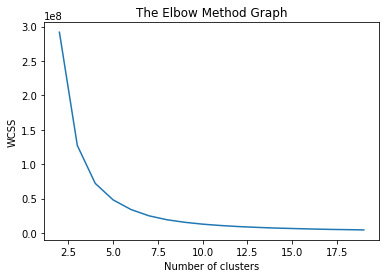

In [8]:
plt.plot(range(2,20),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

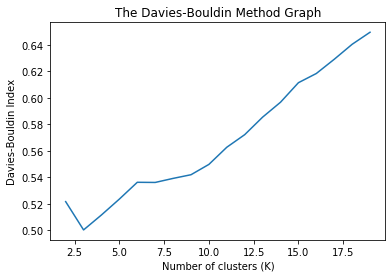

In [9]:
#Plot the Davies-Bouldin graph
plt.plot(range(2,20),dbs)
plt.title('The Davies-Bouldin Method Graph')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show

In [10]:
kmeans = KMeans(n_clusters=7,n_jobs=7,n_init=10,verbose=1)

In [11]:
model = kmeans.fit(X)
clusters = model.predict(X).reshape((len(X),1))

In [12]:
labeled = np.append(X,clusters,axis=1)

In [13]:
cols = ['dev_addr']
onehotcols = list(np.random.rand(onehotlabels.shape[1]))
cols.extend(onehotcols)
cols.extend(numeric)
cols.append('label')

In [14]:
labeled_df = pd.DataFrame(labeled,columns=cols)

In [15]:
inversed = enc_cat.inverse_transform(labeled_df.iloc[:,1:20].values)
inversed = pd.DataFrame(inversed,columns=[x for x in categorical if x!='dev_addr'])
todrop = list(labeled_df.columns)[1:20]
labeled_df = labeled_df.drop(columns=todrop)
labeled_df = labeled_df.join(inversed)
labeled_df[numeric] = scaler.inverse_transform(labeled_df[numeric])
labeled_df[numeric]= labeled_df[numeric].astype(int)
labeled_df.dev_addr= labeled_df.dev_addr.astype(int)
labeled_df.dev_addr = enc_l.inverse_transform(labeled_df.dev_addr)

In [16]:
labeled_df

,dev_addr,FCnt,lsnr,rssic,rssis,rssisd,label,datr,gateway,chan,ant,freq
0,000000ff,190,-18,-108,-126,0,0.0,SF12BW125,7276FF002E061495,23,1,868.5
1,00000043,149,11,-93,-93,0,2.0,SF12BW125,7276FF002E061495,6,0,868.3
2,00000013,207,14,-90,-90,0,4.0,SF12BW125,7276FF002E061495,23,1,868.5
3,00000117,99,-20,-108,-129,0,0.0,SF12BW125,7276FF002E061495,21,1,868.1
4,00000055,161,-6,-107,-115,0,1.0,SF12BW125,7276FF002E061495,21,1,868.1
...,...,...,...,...,...,...,...,...,...,...,...,...
171203,000000bf,197,-8,-111,-120,0,3.0,SF12BW125,7276FF002E050264,7,0,868.5
171204,00000080,1509,0,-106,-109,0,6.0,SF7BW125,7276FF002E061495,5,0,868.1
171205,00000061,1632,-5,-107,-114,1,1.0,SF7BW125,7276FF002E061495,7,0,868.5
171206,00000046,2314,3,-102,-104,0,2.0,SF7BW125,7276FF002E061495,22,1,868.3


In [18]:
color = ["#ff0000", "#0073e6", "#ff751a", "#00ff00", "#e6e600", "#ff00ff","#0000e6",\
         "#006622", "#804000", "#6600ff", "#b30000", "#66ffff","#4d2600"]

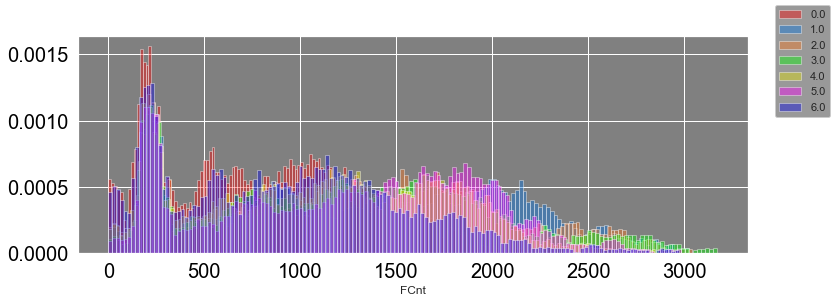

In [19]:
fig = plt.figure(figsize=(12,4))
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey','xtick.color':'black','ytick.color':'black'\
          , 'xtick.labelsize':'20', 'ytick.labelsize':'20'})

sns.set_palette(sns.color_palette(color),13)
for i in labeled_df['label'].unique():
        sns.distplot(labeled_df[labeled_df['label']==i]['FCnt'],label='label',kde=False,bins=150,norm_hist=True)
fig.legend(labels=np.sort(labeled_df['label'].unique()))

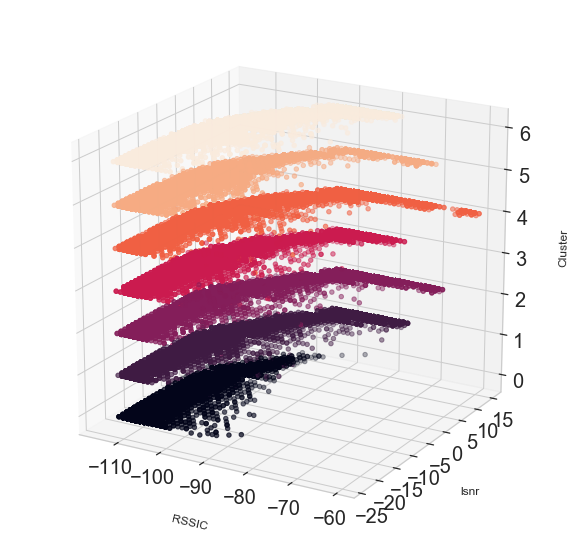

In [62]:
from matplotlib.pyplot import plot, show, draw, figure, cm
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,10))

#ax = Axes3D(fig) # Method 1
ax = fig.add_subplot(111, projection='3d')


ax.scatter(labeled_df.rssic, labeled_df.lsnr, labeled_df.dev_addr, c=labeled_df.label, marker='o',label=)
ax.set_xlabel('RSSIC',labelpad = 20)
ax.set_ylabel('lsnr',labelpad = 20)
ax.set_zlabel('Cluster',labelpad = 20)
ax.view_init(20,None)
plt.show()
#plt.show()

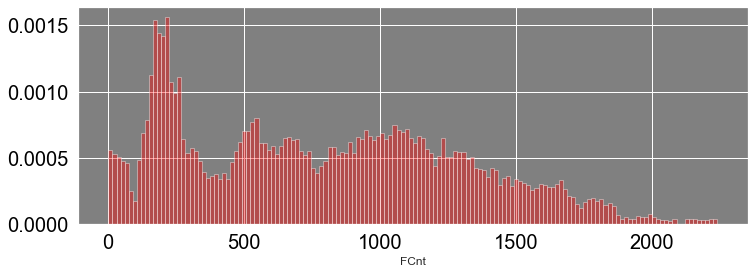

In [21]:
fig = plt.figure(figsize=(12,4))
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey','xtick.color':'black','ytick.color':'black'\
          , 'xtick.labelsize':'20', 'ytick.labelsize':'20'})

sns.set_palette(sns.color_palette(color),13)

sns.distplot(labeled_df[labeled_df['label']==0]['FCnt'],label='label',kde=False,bins=150,norm_hist=True)


In [28]:
count_series = labeled_df.groupby(['dev_addr','label']).size().to_dict()

In [187]:
fig = px.scatter_3d(labeled_df[labeled_df['label'] == 0], x='rssis', y='lsnr', z='rssic',size='FCnt',size_max=15,
              opacity=1,color='datr')
fig.show()

In [184]:
xx = labeled_df.rssis[labeled_df.dev_addr.isin(labeled_df.iloc[:5]['dev_addr'].unique().tolist())]
yy = labeled_df.lsnr[labeled_df.dev_addr.isin(labeled_df.iloc[:5]['dev_addr'].unique().tolist())]
zz = labeled_df.FCnt[labeled_df.dev_addr.isin(labeled_df.iloc[:5]['dev_addr'].unique().tolist())]
s = labeled_df.rssic[labeled_df.dev_addr.isin(labeled_df.iloc[:5]['dev_addr'].unique().tolist())]
fig = px.scatter_3d(labeled_df, x=xx, y=yy, z=zz, size_max=10,size = abs(s),
              color=labeled_df[labeled_df.dev_addr.isin(labeled_df.iloc[:5]['dev_addr'].unique().tolist())]['label']
                    ,opacity=1)
fig.show()